In [2]:
import pandapower as pp
import pandapower.networks as pn
import pandapower as pp
import pandapower.networks as pn
import pandas as pd
from io import StringIO
import numpy as np
# ===========================
# 1. Define Bus Data
# ===========================

bus_data = """bus_name\tvn_kv\tgeodata
Arusha\t220\t(-3.3869, 36.682)
Manyara\t220\t(-4.1884, 35.7589)
Dar es salaam\t220\t(-6.7924, 39.2083)
Pwani\t220\t(-6.331, 38.456)
Dodoma\t400\t(-6.163, 35.7516)
Iringa\t400\t(-7.7667, 35.7)
Mbeya\t220\t(-8.9092, 33.4608)
Morogoro\t220\t(-6.8278, 37.6591)
Mwanza\t220\t(-2.5164, 32.9172)
Shinyanga\t220\t(-3.661, 33.4233)
Singida\t220\t(-4.8161, 34.7436)
Tabora\t220\t(-5.0162, 32.8266)
Tanga\t220\t(-5.30, 38.6)
Zanzibar\t220\t(-6.163, 39.2584)
JNHPP\t400\t(-7.803, 37.85)
Kilimanjaro\t220\t(-3.96, 37.77)
Geita\t220\t(-2.87, 32.17)
"""

buses = pd.read_csv(StringIO(bus_data), sep="\t")
buses['Latitude'] = buses['geodata'].str.extract(r'\((-?\d+\.\d+),')[0].astype(float)
buses['Longitude'] = buses['geodata'].str.extract(r',\s*(-?\d+\.\d+)\)')[0].astype(float)
buses.drop(columns='geodata', inplace=True)


# ===========================
# 2. Create empty network and bus_map
# ===========================

net = pp.create_empty_network()
bus_map = {}

for _, row in buses.iterrows():
    bus_map[row['bus_name']] = pp.create_bus(net, vn_kv=row['vn_kv'], name=row['bus_name'])


# ===========================
# ===========================
# 3. Add Custom Line Types
# 3. Add Custom Line Types
# ===========================

# Base parameters
bluejay_params = {
    "r_ohm_per_km": 0.05136,
    "x_ohm_per_km": 0.4,
    "c_nf_per_km": 12.0,
    "max_i_ka": 0.874,
    "type": "ol",
    "q_mm2": 565.5
}

zebra_params = {
    "r_ohm_per_km": 0.034,
    "x_ohm_per_km": 0.31,
    "c_nf_per_km": 13.0,
    "max_i_ka": 1.056,
    "type": "ol",
    "q_mm2": 485
}

# Create base types
pp.create_std_type(net, bluejay_params, name="ACSR_Bluejay", element="line")
pp.create_std_type(net, zebra_params, name="ACSR_Zebra", element="line")

# Create enhanced types to simulate 3 parallel Bluejay lines
bluejay_3x = {
    "r_ohm_per_km": bluejay_params["r_ohm_per_km"] / 3,
    "x_ohm_per_km": bluejay_params["x_ohm_per_km"] / 3,
    "c_nf_per_km": bluejay_params["c_nf_per_km"] * 3,
    "max_i_ka": bluejay_params["max_i_ka"] * 3,
    "type": "ol",
    "q_mm2": bluejay_params["q_mm2"] * 3
}
pp.create_std_type(net, bluejay_3x, name="ACSR_Bluejay_3x", element="line")


# ===========================
# 4. Define Line Data and Add Lines
# ===========================

lines_data = [
    {"from_bus": "Morogoro", "to_bus": "Iringa", "voltage_kv": 220, "length_km": 130, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Iringa", "to_bus": "Dodoma", "voltage_kv": 220, "length_km": 107, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Mwanza", "voltage_kv": 220, "length_km": 140, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Iringa", "to_bus": "Mbeya", "voltage_kv": 220, "length_km": 220, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dar es salaam", "to_bus": "Pwani", "voltage_kv": 220, "length_km": 48.8, "rating_mva": 999, "cable_type": "ACSR_Bluejay_3x", "area": 565.5 * 3},
    {"from_bus": "Pwani", "to_bus": "Morogoro", "voltage_kv": 220, "length_km": 82, "rating_mva": 999, "cable_type": "ACSR_Bluejay_3x", "area": 565.5 * 3},
    {"from_bus": "JNHPP", "to_bus": "Morogoro", "voltage_kv": 400, "length_km": 160, "rating_mva": 732, "cable_type": "ACSR_Zebra", "area": 485},
    {"from_bus": "Pwani", "to_bus": "Kilimanjaro", "voltage_kv": 220, "length_km": 175, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Kilimanjaro", "to_bus": "Tanga", "voltage_kv": 220, "length_km": 60, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Tabora", "voltage_kv": 220, "length_km": 203, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Singida", "to_bus": "Manyara", "voltage_kv": 220, "length_km": 80, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Manyara", "to_bus": "Arusha", "voltage_kv": 220, "length_km": 22, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dar es salaam", "to_bus": "Zanzibar", "voltage_kv": 220, "length_km": 64, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dodoma", "to_bus": "Singida", "voltage_kv": 220, "length_km": 216.5, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Singida", "to_bus": "Shinyanga", "voltage_kv": 220, "length_km": 228.9, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Geita", "voltage_kv": 220, "length_km": 120, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5}
]

# ===========================
# 5. Add Transformer (only for voltage level changes)
# ===========================

# Define transformer type once
standard_tx = {
    "sn_mva": 315,
    "vn_hv_kv": 400,
    "vn_lv_kv": 220,
    "vk_percent": 12,
    "vkr_percent": 0.28,
    "pfe_kw": 0,
    "i0_percent": 0.1,
    "shift_degree": 0
}
pp.create_std_type(net, standard_tx, name="400/220kV_TX", element="trafo")

# Add lines or transformers based on voltage level match
for line in lines_data:
    from_bus = bus_map[line['from_bus']]
    to_bus = bus_map[line['to_bus']]

    from_kv = buses.loc[buses['bus_name'] == line['from_bus'], 'vn_kv'].values[0]
    to_kv = buses.loc[buses['bus_name'] == line['to_bus'], 'vn_kv'].values[0]

    if from_kv == to_kv:
        # Add line if voltages match
        pp.create_line(
            net,
            from_bus=from_bus,
            to_bus=to_bus,
            length_km=line['length_km'],
            std_type=line['cable_type'],
            name=f"Line_{line['from_bus']}_to_{line['to_bus']}"
        )
    else:
        # Add transformer if voltages differ
        hv_bus = from_bus if from_kv > to_kv else to_bus
        lv_bus = to_bus if from_kv > to_kv else from_bus

        pp.create_transformer(
            net,
            hv_bus=hv_bus,
            lv_bus=lv_bus,
            std_type="400/220kV_TX",
            name=f"TX_{line['from_bus']}_to_{line['to_bus']}"
        )
# ===========================
# 5. Add Generators and External Grid
# ===========================

gen_data = {
    "gen_name": ["JNHPP", "Morogoro", "Dodoma", "Kilimanjaro", "Dar es salaam"],
    "p_mw": [540, 420, 20, 5, 600]
}
gen_df = pd.DataFrame(gen_data)

for _, row in gen_df.iterrows():
    bus_idx = bus_map[row['gen_name']]
    if row['gen_name'] == "JNHPP":
        pp.create_ext_grid(net, bus=bus_idx, vm_pu=1.0, name="Slack_JNHPP")
    else:
        pp.create_gen(net, bus=bus_idx, p_mw=row['p_mw'], vm_pu=1.0, name=row['gen_name'])


# ===========================
# 6. Add Loads
# ===========================

load_data = {
    "bus_name": [
        "Arusha", "Manyara", "Dar es salaam", "Pwani", "Dodoma", "Iringa",
        "Kilimanjaro", "Mbeya", "Morogoro", "Mwanza", "Shinyanga",
        "Singida", "Tabora", "Tanga", "Zanzibar", "Geita"
    ],
    "vn_kv": [
        220, 220, 220, 220, 220, 400, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220
    ],
    "p_mw": [
        112, 13, 989, 44.6, 31.51, 33, 66, 20.28, 86, 35, 45, 23, 23, 116, 113.89, 26
    ],
    "q_mvar": [
        36.81, 4.27, 325.07, 14.66, 10.36, 10.85, 21.69, 6.66, 28.27, 11.5, 14.79,
        7.56, 7.56, 38.13, 37.43, 8.55
    ]
}
load_df = pd.DataFrame(load_data)

for _, row in load_df.iterrows():
    bus_idx = bus_map[row['bus_name']]
    pp.create_load(net, 
                   bus=bus_idx, 
                   p_mw=row['p_mw'], 
                   q_mvar=row['q_mvar'], 
                   name=f"Load_{row['bus_name']}")



import copy
import pandas as pd
import pandapower as pp

import pandas as pd
import pandapower as pp

def set_capacity(net, bus, capacity_mw, gen_type='solar'):
    """Set generation at a bus or create a new generator if not present."""
    gen_idx = net.gen[net.gen.bus == bus].index
    if len(gen_idx) > 0:
        net.gen.at[gen_idx[0], 'p_mw'] = capacity_mw
    else:
        pp.create_gen(net, bus=bus, p_mw=capacity_mw, vm_pu=1.02, name=f"{gen_type}_gen_{bus}")

def check_violations(net, buses_to_check=None):
    """Check voltage and line/transformer loading violations."""
    if buses_to_check is None:
        buses_to_check = net.bus.index

    voltages = net.res_bus.vm_pu.loc[buses_to_check]
    voltage_violations = voltages[(voltages < 0.95) | (voltages > 1.05)]

    line_violations = net.res_line.loading_percent[net.res_line.loading_percent > 100]
    trafo_violations = net.res_trafo.loading_percent[net.res_trafo.loading_percent > 100] if not net.trafo.empty else []
    trafo3w_violations = net.res_trafo3w.loading_percent[net.res_trafo3w.loading_percent > 100] if not net.trafo3w.empty else []

    total_overloading_violations = len(line_violations) + len(trafo_violations) + len(trafo3w_violations)

    return len(voltage_violations), total_overloading_violations

def test_all_capacity_pairs_representative(
    net, singida_bus, shinyanga_bus,
    max_solar=400, max_wind=400, step=50
):
    results = []

    # ---------------------- 📥 Load Solar and Wind CSVs ----------------------
    solar_df = pd.read_csv("Singida_Solar.csv", skiprows=3, engine='python')
    solar_df.columns = solar_df.columns.str.strip()
    solar_df['local_time'] = pd.to_datetime(solar_df['local_time'])
    solar_df.set_index('local_time', inplace=True)

    wind_df = pd.read_csv("Shinyanga_Wind.csv", skiprows=3, engine='python')
    wind_df.columns = wind_df.columns.str.strip()
    wind_df['local_time'] = pd.to_datetime(wind_df['local_time'])
    wind_df.set_index('local_time', inplace=True)

    # ---------------------- 📊 Combine solar and wind CF ----------------------
    cf_df = solar_df.join(wind_df, how='inner', lsuffix='_solar', rsuffix='_wind')
    cf_df.rename(columns={
        'electricity_solar': 'solar_cf',
        'electricity_wind': 'wind_cf'
    }, inplace=True)

    # ---------------------- 🎯 Pick representative hours ----------------------
    peak_solar_idx = cf_df['solar_cf'].idxmax()
    peak_wind_idx  = cf_df['wind_cf'].idxmax()
    low_both_idx   = cf_df[(cf_df['solar_cf'] < 0.1) & (cf_df['wind_cf'] < 0.1)].index[0]

    representative_hours = {
        "peak_solar": peak_solar_idx,
        "peak_wind": peak_wind_idx,
        "low_both": low_both_idx
    }

    # ---------------------- 🔁 Loop over capacity pairs ----------------------
    for solar_mw in range(0, max_solar + step, step):
        for wind_mw in range(0, max_wind + step, step):
            for scenario, t in representative_hours.items():
                solar_cf_hourly = cf_df.loc[t, 'solar_cf']
                wind_cf_hourly  = cf_df.loc[t, 'wind_cf']

                # Calculate actual injections
                solar_injection = solar_mw * solar_cf_hourly
                wind_injection  = wind_mw * wind_cf_hourly

                # Inject into grid
                set_capacity(net, singida_bus, solar_injection, 'solar')
                set_capacity(net, shinyanga_bus, wind_injection, 'wind')
                pp.runpp(net)

                # Check violations
                voltage_violations, line_loading_violations = check_violations(net, net.bus.index)

                passed = (voltage_violations == 0) and (line_loading_violations == 0)

                if passed:
                    solar_capacity_to_install = solar_mw / solar_cf_hourly if solar_cf_hourly > 0 else 0
                    wind_capacity_to_install  = wind_mw / wind_cf_hourly if wind_cf_hourly > 0 else 0
                else:
                    solar_capacity_to_install = 'N/A'
                    wind_capacity_to_install  = 'N/A'

                results.append({
                    'Scenario': scenario,
                    'Hour': t,
                    'Solar_Injection_MW': solar_injection,
                    'Wind_Injection_MW': wind_injection,
                    'Voltage_Violations': voltage_violations,
                    'Line_Loading_Violations': line_loading_violations,
                    'Passed': passed,
                    'Solar_Capacity_to_Install': solar_capacity_to_install,
                    'Wind_Capacity_to_Install': wind_capacity_to_install
                })

    return pd.DataFrame(results)


# ---------------------- Example Usage ----------------------
singida_bus = 10
shinyanga_bus = 9

df = test_all_capacity_pairs_representative(net, singida_bus, shinyanga_bus, max_solar=400, max_wind=400, step=50)


# Show all viable (no-violation) solutions
print(df[df['Passed'] == True])

# Save results to file
df.to_csv('final_sizing.csv', index=False)



       Scenario                Hour  Solar_Injection_MW  Wind_Injection_MW  \
183  peak_solar 2023-06-07 12:00:00              238.50             220.15   
186  peak_solar 2023-06-07 12:00:00              238.50             251.60   
187   peak_wind 2023-08-30 08:00:00              101.10             376.80   
207  peak_solar 2023-06-07 12:00:00              278.25             188.70   
210  peak_solar 2023-06-07 12:00:00              278.25             220.15   
213  peak_solar 2023-06-07 12:00:00              278.25             251.60   
214   peak_wind 2023-08-30 08:00:00              117.95             376.80   
231  peak_solar 2023-06-07 12:00:00              318.00             157.25   
234  peak_solar 2023-06-07 12:00:00              318.00             188.70   
237  peak_solar 2023-06-07 12:00:00              318.00             220.15   
238   peak_wind 2023-08-30 08:00:00              134.80             329.70   
240  peak_solar 2023-06-07 12:00:00              318.00         

In [6]:
# ✅ Filter only passed cases
passed_df = df[df['Passed'] == True]

if passed_df.empty:
    print("⚠️ No feasible solar/wind combinations found without violations.")
else:
    # ------------------ Injection ranges ------------------
    min_solar_inj = passed_df['Solar_Injection_MW'].min()
    max_solar_inj = passed_df['Solar_Injection_MW'].max()

    min_wind_inj = passed_df['Wind_Injection_MW'].min()
    max_wind_inj = passed_df['Wind_Injection_MW'].max()

    # ------------------ Installed capacity ranges ------------------
    # (filter out 'N/A' if they exist, convert to numeric)
    solar_cap_series = pd.to_numeric(passed_df['Solar_Capacity_to_Install'], errors='coerce').dropna()
    wind_cap_series  = pd.to_numeric(passed_df['Wind_Capacity_to_Install'], errors='coerce').dropna()

    min_solar_cap = solar_cap_series.min()
    max_solar_cap = solar_cap_series.max()

    min_wind_cap = wind_cap_series.min()
    max_wind_cap = wind_cap_series.max()

    # ------------------ Print results ------------------
    print("✅ Feasible deployment ranges (with zero violations):")
    print(f"  Solar Injection:   {min_solar_inj:.2f} MW → {max_solar_inj:.2f} MW")
    print(f"  Wind Injection:    {min_wind_inj:.2f} MW → {max_wind_inj:.2f} MW\n")

    print(f"  Solar Capacity:    {min_solar_cap:.2f} MW → {max_solar_cap:.2f} MW (installed farm size)")
    print(f"  Wind Capacity:     {min_wind_cap:.2f} MW → {max_wind_cap:.2f} MW (installed farm size)")


✅ Feasible deployment ranges (with zero violations):
  Solar Injection:   101.10 MW → 318.00 MW
  Wind Injection:    157.25 MW → 376.80 MW

  Solar Capacity:    377.36 MW → 1186.94 MW (installed farm size)
  Wind Capacity:     371.55 MW → 635.93 MW (installed farm size)


In [16]:
import pandas as pd
from io import StringIO
import pandapower as pp

# ===========================
# 1. Define Bus Data
# ===========================

bus_data = """bus_name\tvn_kv\tgeodata
Arusha\t220\t(-3.3869, 36.682)
Manyara\t220\t(-4.1884, 35.7589)
Dar es salaam\t220\t(-6.7924, 39.2083)
Pwani\t220\t(-6.331, 38.456)
Dodoma\t400\t(-6.163, 35.7516)
Iringa\t400\t(-7.7667, 35.7)
Mbeya\t220\t(-8.9092, 33.4608)
Morogoro\t220\t(-6.8278, 37.6591)
Mwanza\t220\t(-2.5164, 32.9172)
Shinyanga\t220\t(-3.661, 33.4233)
Singida\t220\t(-4.8161, 34.7436)
Tabora\t220\t(-5.0162, 32.8266)
Tanga\t220\t(-5.30, 38.6)
Zanzibar\t220\t(-6.163, 39.2584)
JNHPP\t400\t(-7.803, 37.85)
Kilimanjaro\t220\t(-3.96, 37.77)
Geita\t220\t(-2.87, 32.17)
"""

buses = pd.read_csv(StringIO(bus_data), sep="\t")
buses['Latitude'] = buses['geodata'].str.extract(r'\((-?\d+\.\d+),')[0].astype(float)
buses['Longitude'] = buses['geodata'].str.extract(r',\s*(-?\d+\.\d+)\)')[0].astype(float)
buses.drop(columns='geodata', inplace=True)


# ===========================
# 2. Create empty network and bus_map
# ===========================

net = pp.create_empty_network()
bus_map = {}

for _, row in buses.iterrows():
    bus_map[row['bus_name']] = pp.create_bus(net, vn_kv=row['vn_kv'], name=row['bus_name'])


# ===========================
# ===========================
# 3. Add Custom Line Types
# 3. Add Custom Line Types
# ===========================

# Base parameters
bluejay_params = {
    "r_ohm_per_km": 0.05136,
    "x_ohm_per_km": 0.4,
    "c_nf_per_km": 12.0,
    "max_i_ka": 0.874,
    "type": "ol",
    "q_mm2": 565.5
}

zebra_params = {
    "r_ohm_per_km": 0.034,
    "x_ohm_per_km": 0.31,
    "c_nf_per_km": 13.0,
    "max_i_ka": 1.056,
    "type": "ol",
    "q_mm2": 485
}

# Create base types
pp.create_std_type(net, bluejay_params, name="ACSR_Bluejay", element="line")
pp.create_std_type(net, zebra_params, name="ACSR_Zebra", element="line")

# Create enhanced types to simulate 3 parallel Bluejay lines
bluejay_3x = {
    "r_ohm_per_km": bluejay_params["r_ohm_per_km"] / 3,
    "x_ohm_per_km": bluejay_params["x_ohm_per_km"] / 3,
    "c_nf_per_km": bluejay_params["c_nf_per_km"] * 3,
    "max_i_ka": bluejay_params["max_i_ka"] * 3,
    "type": "ol",
    "q_mm2": bluejay_params["q_mm2"] * 3
}
pp.create_std_type(net, bluejay_3x, name="ACSR_Bluejay_3x", element="line")

# Create enhanced types to simulate 3 parallel Bluejay lines
zebra_3x = {
    "r_ohm_per_km": zebra_params["r_ohm_per_km"] / 3,
    "x_ohm_per_km": zebra_params["x_ohm_per_km"] / 3,
    "c_nf_per_km": zebra_params["c_nf_per_km"] * 3,
    "max_i_ka": zebra_params["max_i_ka"] * 3,
    "type": "ol",
    "q_mm2": zebra_params["q_mm2"] * 3
}
pp.create_std_type(net, zebra_3x, name="ACSR_Zebra_3x", element="line")
# ===========================
# 4. Define Line Data and Add Lines
# ===========================

lines_data = [
    {"from_bus": "Morogoro", "to_bus": "Iringa", "voltage_kv": 220, "length_km": 130, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Iringa", "to_bus": "Dodoma", "voltage_kv": 220, "length_km": 107, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Mwanza", "voltage_kv": 220, "length_km": 140, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Iringa", "to_bus": "Mbeya", "voltage_kv": 220, "length_km": 220, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dar es salaam", "to_bus": "Pwani", "voltage_kv": 220, "length_km": 48.8, "rating_mva": 999, "cable_type": "ACSR_Bluejay_3x", "area": 565.5 * 3},
    {"from_bus": "Pwani", "to_bus": "Morogoro", "voltage_kv": 220, "length_km": 82, "rating_mva": 999, "cable_type": "ACSR_Bluejay_3x", "area": 565.5 * 3},
    {"from_bus": "JNHPP", "to_bus": "Morogoro", "voltage_kv": 400, "length_km": 160, "rating_mva": 732, "cable_type": "ACSR_Zebra", "area": 485},
    {"from_bus": "Pwani", "to_bus": "Kilimanjaro", "voltage_kv": 220, "length_km": 175, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Kilimanjaro", "to_bus": "Tanga", "voltage_kv": 220, "length_km": 60, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Tabora", "voltage_kv": 220, "length_km": 203, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Singida", "to_bus": "Manyara", "voltage_kv": 220, "length_km": 80, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Manyara", "to_bus": "Arusha", "voltage_kv": 220, "length_km": 22, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dar es salaam", "to_bus": "Zanzibar", "voltage_kv": 220, "length_km": 64, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dodoma", "to_bus": "Singida", "voltage_kv": 220, "length_km": 216.5, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Singida", "to_bus": "Shinyanga", "voltage_kv": 220, "length_km": 228.9, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Geita", "voltage_kv": 220, "length_km": 120, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5}
]

# ===========================
# 5. Add Transformer (only for voltage level changes)
# ===========================

# Define transformer type once
standard_tx = {
    "sn_mva": 600,
    "vn_hv_kv": 400,
    "vn_lv_kv": 220,
    "vk_percent": 12,
    "vkr_percent": 0.28,
    "pfe_kw": 0,
    "i0_percent": 0.1,
    "shift_degree": 0
}
pp.create_std_type(net, standard_tx, name="400/220kV_TX", element="trafo")

# Add lines or transformers based on voltage level match
for line in lines_data:
    from_bus = bus_map[line['from_bus']]
    to_bus = bus_map[line['to_bus']]

    from_kv = buses.loc[buses['bus_name'] == line['from_bus'], 'vn_kv'].values[0]
    to_kv = buses.loc[buses['bus_name'] == line['to_bus'], 'vn_kv'].values[0]

    if from_kv == to_kv:
        # Add line if voltages match
        pp.create_line(
            net,
            from_bus=from_bus,
            to_bus=to_bus,
            length_km=line['length_km'],
            std_type=line['cable_type'],
            name=f"Line_{line['from_bus']}_to_{line['to_bus']}"
        )
    else:
        # Add transformer if voltages differ
        hv_bus = from_bus if from_kv > to_kv else to_bus
        lv_bus = to_bus if from_kv > to_kv else from_bus

        pp.create_transformer(
            net,
            hv_bus=hv_bus,
            lv_bus=lv_bus,
            std_type="400/220kV_TX",
            name=f"TX_{line['from_bus']}_to_{line['to_bus']}"
        )
# ===========================
# 5. Add Generators and External Grid
# ===========================

gen_data = {
    "gen_name": ["JNHPP", "Morogoro", "Dodoma", "Kilimanjaro","Singida", "Shinyanga", "Dar es salaam"],
    "p_mw": [540, 420, 20, 5, 101.10, 157.25, 600]
}
gen_df = pd.DataFrame(gen_data)

for _, row in gen_df.iterrows():
    bus_idx = bus_map[row['gen_name']]
    if row['gen_name'] == "JNHPP":
        pp.create_ext_grid(net, bus=bus_idx, vm_pu=1.0, name="Slack_JNHPP")
    else:
        pp.create_gen(net, bus=bus_idx, p_mw=row['p_mw'], vm_pu=1.0, name=row['gen_name'])


# ===========================
# 6. Add Loads
# ===========================

load_data = {
    "bus_name": [
        "Arusha", "Manyara", "Dar es salaam", "Pwani", "Dodoma", "Iringa",
        "Kilimanjaro", "Mbeya", "Morogoro", "Mwanza", "Shinyanga",
        "Singida", "Tabora", "Tanga", "Zanzibar", "Geita"
    ],
    "vn_kv": [
        220, 220, 220, 220, 220, 400, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220
    ],
    "p_mw": [
        112, 13, 989, 44.6, 31.51, 33, 66, 20.28, 86, 35, 45, 23, 23, 116, 113.89, 26
    ],
    "q_mvar": [
        36.81, 4.27, 325.07, 14.66, 10.36, 10.85, 21.69, 6.66, 28.27, 11.5, 14.79,
        7.56, 7.56, 38.13, 37.43, 8.55
    ]
}
load_df = pd.DataFrame(load_data)

for _, row in load_df.iterrows():
    bus_idx = bus_map[row['bus_name']]
    pp.create_load(net, 
                   bus=bus_idx, 
                   p_mw=row['p_mw'], 
                   q_mvar=row['q_mvar'], 
                   name=f"Load_{row['bus_name']}")


# ===========================
# 7. Run Power Flow and Print Results
# ===========================

pp.runpp(net)


In [17]:
import pandas as pd
import numpy as np
from IPython.display import display

# --- Table 1: Lines and Transformers ---

# Voltage drops and line status
voltage_drop = np.abs(net.res_bus.vm_pu.loc[net.line.from_bus].values - net.res_bus.vm_pu.loc[net.line.to_bus].values)
line_loading = net.res_line.loading_percent.values
vm_from = net.res_bus.vm_pu.loc[net.line.from_bus].values
vm_to = net.res_bus.vm_pu.loc[net.line.to_bus].values

line_status = []
for v_from, v_to, load in zip(vm_from, vm_to, line_loading):
    status = []
    if v_from < 0.95 or v_from > 1.05 or v_to < 0.95 or v_to > 1.05:
        status.append("Voltage Violation")
    if load > 90:
        status.append("Overload")
    line_status.append(" ".join(status) if status else "Normal")

line_df = pd.DataFrame({
    'From Bus': net.line.from_bus.map(net.bus['name']).reset_index(drop=True),
    'To Bus': net.line.to_bus.map(net.bus['name']).reset_index(drop=True),
    'Voltage Drop (p.u.)': pd.Series(voltage_drop).round(4),
    'Loading (%)': pd.Series(line_loading).round(1),
    'Connection Type': 'Line',
    'Status': line_status
})

# Transformer drops and status
trafo_vdrops = []
trafo_status = []
trafo_loading = net.res_trafo.loading_percent.values
vm_hv = net.res_bus.vm_pu.loc[net.trafo.hv_bus].values
vm_lv = net.res_bus.vm_pu.loc[net.trafo.lv_bus].values

for v_hv, v_lv, load in zip(vm_hv, vm_lv, trafo_loading):
    drop = abs(v_hv - v_lv)
    trafo_vdrops.append(drop)
    status = []
    if v_lv < 0.95 or v_lv > 1.05:
        status.append("Voltage Violation")
    if load > 90:
        status.append("Overload")
    trafo_status.append(" ".join(status) if status else "Normal")

trafo_df = pd.DataFrame({
    'From Bus': net.trafo.hv_bus.map(net.bus['name']).reset_index(drop=True),
    'To Bus': net.trafo.lv_bus.map(net.bus['name']).reset_index(drop=True),
    'Voltage Drop (p.u.)': pd.Series(trafo_vdrops).round(4),
    'Loading (%)': pd.Series(trafo_loading).round(1),
    'Connection Type': 'Transformer',
    'Status': trafo_status
})

combined_df = pd.concat([line_df, trafo_df], ignore_index=True)

# --- Table 2: Bus Voltage Status ---

bus_voltage = net.res_bus.vm_pu.round(4)
bus_names = net.bus['name']

bus_status = ["Voltage Violation" if v < 0.95 or v > 1.05 else "Normal" for v in bus_voltage]

bus_df = pd.DataFrame({
    'Bus Name': bus_names,
    'Voltage (p.u.)': bus_voltage,
    'Status': bus_status
})

# --- Style and Display ---

def style_table(df, numeric_format={}):
    return (
        df.style
        .set_table_attributes("style='border-collapse: collapse; width: 100%;'")
        .set_properties(**{
            'border': '1px solid black',
            'text-align': 'right',
            'padding': '4px',
            'color': 'black',
            'background-color': 'white'
        })
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('border', '1px solid black'),
                ('text-align', 'center'),
                ('padding', '6px'),
                ('font-weight', 'bold'),
                ('color', 'black'),
                ('background-color', 'white')
            ]}
        ])
        .format(numeric_format)
    )

# Display styled tables
print("Line and Transformer Summary:")
display(style_table(combined_df, {'Voltage Drop (p.u.)': '{:.4f}', 'Loading (%)': '{:.1f}'}))

print("\n Bus Voltage Status:")
display(style_table(bus_df, {'Voltage (p.u.)': '{:.4f}'}))


Line and Transformer Summary:


,From Bus,To Bus,Voltage Drop (p.u.),Loading (%),Connection Type,Status
0,Iringa,Dodoma,0.0017,7.8,Line,Normal
1,Shinyanga,Mwanza,0.0047,11.2,Line,Normal
2,Dar es salaam,Pwani,0.0063,52.3,Line,Normal
3,Pwani,Morogoro,0.0063,75.5,Line,Normal
4,Pwani,Kilimanjaro,0.0063,56.0,Line,Normal
5,Kilimanjaro,Tanga,0.0260,37.6,Line,Normal
6,Shinyanga,Tabora,0.0133,11.1,Line,Normal
7,Singida,Manyara,0.0375,41.1,Line,Normal
8,Manyara,Arusha,0.0096,37.1,Line,Normal
9,Dar es salaam,Zanzibar,0.0271,37.0,Line,Normal



 Bus Voltage Status:


,Bus Name,Voltage (p.u.),Status
0,Arusha,0.9529,Normal
1,Manyara,0.9625,Normal
2,Dar es salaam,1.0000,Normal
3,Pwani,0.9937,Normal
4,Dodoma,1.0000,Normal
5,Iringa,1.0017,Normal
6,Mbeya,1.0002,Normal
7,Morogoro,1.0000,Normal
8,Mwanza,0.9953,Normal
9,Shinyanga,1.0000,Normal


In [20]:
import pandas as pd
import numpy as np
from IPython.display import display

# --- Table 1: Lines and Transformers ---

# Voltage drops and line status
voltage_drop = np.abs(net.res_bus.vm_pu.loc[net.line.from_bus].values - net.res_bus.vm_pu.loc[net.line.to_bus].values)
line_loading = net.res_line.loading_percent.values
vm_from = net.res_bus.vm_pu.loc[net.line.from_bus].values
vm_to = net.res_bus.vm_pu.loc[net.line.to_bus].values

line_status = []
for v_from, v_to, load in zip(vm_from, vm_to, line_loading):
    status = []
    if v_from < 0.95 or v_from > 1.05 or v_to < 0.95 or v_to > 1.05:
        status.append("⚠️ Voltage Violation")
    if load > 90:
        status.append("⚠️ Overload")
    line_status.append(" ".join(status) if status else "Normal")

line_df = pd.DataFrame({
    'From Bus': net.line.from_bus.map(net.bus['name']).reset_index(drop=True),
    'To Bus': net.line.to_bus.map(net.bus['name']).reset_index(drop=True),
    'Voltage Drop (p.u.)': pd.Series(voltage_drop).round(4),
    'Loading (%)': pd.Series(line_loading).round(1),
    'Connection Type': 'Line',
    'Status': line_status
})

# Transformer drops and status
trafo_vdrops = []
trafo_status = []
trafo_loading = net.res_trafo.loading_percent.values
vm_hv = net.res_bus.vm_pu.loc[net.trafo.hv_bus].values
vm_lv = net.res_bus.vm_pu.loc[net.trafo.lv_bus].values

for v_hv, v_lv, load in zip(vm_hv, vm_lv, trafo_loading):
    drop = abs(v_hv - v_lv)
    trafo_vdrops.append(drop)
    status = []
    if v_lv < 0.95 or v_lv > 1.05:
        status.append("⚠️ Voltage Violation")
    if load > 90:
        status.append("⚠️ Overload")
    trafo_status.append(" ".join(status) if status else "Normal")

trafo_df = pd.DataFrame({
    'From Bus': net.trafo.hv_bus.map(net.bus['name']).reset_index(drop=True),
    'To Bus': net.trafo.lv_bus.map(net.bus['name']).reset_index(drop=True),
    'Voltage Drop (p.u.)': pd.Series(trafo_vdrops).round(4),
    'Loading (%)': pd.Series(trafo_loading).round(1),
    'Connection Type': 'Transformer',
    'Status': trafo_status
})

combined_df = pd.concat([line_df, trafo_df], ignore_index=True)

# --- Table 2: Bus Voltage Status ---

bus_voltage = net.res_bus.vm_pu.round(4)
bus_names = net.bus['name']

bus_status = ["⚠️ Voltage Violation" if v < 0.95 or v > 1.05 else "Normal" for v in bus_voltage]

bus_df = pd.DataFrame({
    'Bus Name': bus_names,
    'Voltage (p.u.)': bus_voltage,
    'Status': bus_status
})

# --- Style and Display ---

def style_table(df, numeric_format={}):
    return (
        df.style
        .set_table_attributes("style='border-collapse: collapse; width: 100%;'")
        .set_properties(**{
            'border': '1px solid black',
            'text-align': 'right',
            'padding': '4px',
            'color': 'black',
            'background-color': 'white'
        })
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('border', '1px solid black'),
                ('text-align', 'center'),
                ('padding', '6px'),
                ('font-weight', 'bold'),
                ('color', 'black'),
                ('background-color', 'white')
            ]}
        ])
        .format(numeric_format)
    )

# Display styled tables
print("🔌 Line and Transformer Summary:")
display(style_table(combined_df, {'Voltage Drop (p.u.)': '{:.4f}', 'Loading (%)': '{:.1f}'}))

print("\n🔋 Bus Voltage Status:")
display(style_table(bus_df, {'Voltage (p.u.)': '{:.4f}'}))


🔌 Line and Transformer Summary:


,From Bus,To Bus,Voltage Drop (p.u.),Loading (%),Connection Type,Status
0,Iringa,Dodoma,0.0017,7.8,Line,Normal
1,Shinyanga,Mwanza,0.0047,11.2,Line,Normal
2,Dar es salaam,Pwani,0.0063,52.3,Line,Normal
3,Pwani,Morogoro,0.0063,75.5,Line,Normal
4,Pwani,Kilimanjaro,0.0063,56.0,Line,Normal
5,Kilimanjaro,Tanga,0.0260,37.6,Line,Normal
6,Shinyanga,Tabora,0.0133,11.1,Line,Normal
7,Singida,Manyara,0.0375,41.1,Line,Normal
8,Manyara,Arusha,0.0096,37.1,Line,Normal
9,Dar es salaam,Zanzibar,0.0271,37.0,Line,Normal



🔋 Bus Voltage Status:


,Bus Name,Voltage (p.u.),Status
0,Arusha,0.9529,Normal
1,Manyara,0.9625,Normal
2,Dar es salaam,1.0000,Normal
3,Pwani,0.9937,Normal
4,Dodoma,1.0000,Normal
5,Iringa,1.0017,Normal
6,Mbeya,1.0002,Normal
7,Morogoro,1.0000,Normal
8,Mwanza,0.9953,Normal
9,Shinyanga,1.0000,Normal


In [22]:
import pandas as pd
from io import StringIO
import pandapower as pp

# ===========================
# 1. Define Bus Data
# ===========================

bus_data = """bus_name\tvn_kv\tgeodata
Arusha\t220\t(-3.3869, 36.682)
Manyara\t220\t(-4.1884, 35.7589)
Dar es salaam\t220\t(-6.7924, 39.2083)
Pwani\t220\t(-6.331, 38.456)
Dodoma\t400\t(-6.163, 35.7516)
Iringa\t400\t(-7.7667, 35.7)
Mbeya\t220\t(-8.9092, 33.4608)
Morogoro\t220\t(-6.8278, 37.6591)
Mwanza\t220\t(-2.5164, 32.9172)
Shinyanga\t220\t(-3.661, 33.4233)
Singida\t220\t(-4.8161, 34.7436)
Tabora\t220\t(-5.0162, 32.8266)
Tanga\t220\t(-5.30, 38.6)
Zanzibar\t220\t(-6.163, 39.2584)
JNHPP\t400\t(-7.803, 37.85)
Kilimanjaro\t220\t(-3.96, 37.77)
Geita\t220\t(-2.87, 32.17)
"""

buses = pd.read_csv(StringIO(bus_data), sep="\t")
buses['Latitude'] = buses['geodata'].str.extract(r'\((-?\d+\.\d+),')[0].astype(float)
buses['Longitude'] = buses['geodata'].str.extract(r',\s*(-?\d+\.\d+)\)')[0].astype(float)
buses.drop(columns='geodata', inplace=True)


# ===========================
# 2. Create empty network and bus_map
# ===========================

net = pp.create_empty_network()
bus_map = {}

for _, row in buses.iterrows():
    bus_map[row['bus_name']] = pp.create_bus(net, vn_kv=row['vn_kv'], name=row['bus_name'])


# ===========================
# ===========================
# 3. Add Custom Line Types
# 3. Add Custom Line Types
# ===========================

# Base parameters
bluejay_params = {
    "r_ohm_per_km": 0.05136,
    "x_ohm_per_km": 0.4,
    "c_nf_per_km": 12.0,
    "max_i_ka": 0.874,
    "type": "ol",
    "q_mm2": 565.5
}

zebra_params = {
    "r_ohm_per_km": 0.034,
    "x_ohm_per_km": 0.31,
    "c_nf_per_km": 13.0,
    "max_i_ka": 1.056,
    "type": "ol",
    "q_mm2": 485
}

# Create base types
pp.create_std_type(net, bluejay_params, name="ACSR_Bluejay", element="line")
pp.create_std_type(net, zebra_params, name="ACSR_Zebra", element="line")

# Create enhanced types to simulate 3 parallel Bluejay lines
bluejay_3x = {
    "r_ohm_per_km": bluejay_params["r_ohm_per_km"] / 3,
    "x_ohm_per_km": bluejay_params["x_ohm_per_km"] / 3,
    "c_nf_per_km": bluejay_params["c_nf_per_km"] * 3,
    "max_i_ka": bluejay_params["max_i_ka"] * 3,
    "type": "ol",
    "q_mm2": bluejay_params["q_mm2"] * 3
}
pp.create_std_type(net, bluejay_3x, name="ACSR_Bluejay_3x", element="line")


# ===========================
# 4. Define Line Data and Add Lines
# ===========================

lines_data = [
    {"from_bus": "Morogoro", "to_bus": "Iringa", "voltage_kv": 220, "length_km": 130, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Iringa", "to_bus": "Dodoma", "voltage_kv": 220, "length_km": 107, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Mwanza", "voltage_kv": 220, "length_km": 140, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Iringa", "to_bus": "Mbeya", "voltage_kv": 220, "length_km": 220, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dar es salaam", "to_bus": "Pwani", "voltage_kv": 220, "length_km": 48.8, "rating_mva": 999, "cable_type": "ACSR_Bluejay_3x", "area": 565.5 * 3},
    {"from_bus": "Pwani", "to_bus": "Morogoro", "voltage_kv": 220, "length_km": 82, "rating_mva": 999, "cable_type": "ACSR_Bluejay_3x", "area": 565.5 * 3},
    {"from_bus": "JNHPP", "to_bus": "Morogoro", "voltage_kv": 400, "length_km": 160, "rating_mva": 732, "cable_type": "ACSR_Zebra", "area": 485},
    {"from_bus": "Pwani", "to_bus": "Kilimanjaro", "voltage_kv": 220, "length_km": 175, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Kilimanjaro", "to_bus": "Tanga", "voltage_kv": 220, "length_km": 60, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Tabora", "voltage_kv": 220, "length_km": 203, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Singida", "to_bus": "Manyara", "voltage_kv": 220, "length_km": 80, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Manyara", "to_bus": "Arusha", "voltage_kv": 220, "length_km": 22, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dar es salaam", "to_bus": "Zanzibar", "voltage_kv": 220, "length_km": 64, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dodoma", "to_bus": "Singida", "voltage_kv": 220, "length_km": 216.5, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Singida", "to_bus": "Shinyanga", "voltage_kv": 220, "length_km": 228.9, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Geita", "voltage_kv": 220, "length_km": 120, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5}
]

# ===========================
# 5. Add Transformer (only for voltage level changes)
# ===========================

# Define transformer type once
standard_tx = {
    "sn_mva": 800,
    "vn_hv_kv": 400,
    "vn_lv_kv": 220,
    "vk_percent": 12,
    "vkr_percent": 0.28,
    "pfe_kw": 0,
    "i0_percent": 0.1,
    "shift_degree": 0
}
pp.create_std_type(net, standard_tx, name="400/220kV_TX", element="trafo")

# Add lines or transformers based on voltage level match
for line in lines_data:
    from_bus = bus_map[line['from_bus']]
    to_bus = bus_map[line['to_bus']]

    from_kv = buses.loc[buses['bus_name'] == line['from_bus'], 'vn_kv'].values[0]
    to_kv = buses.loc[buses['bus_name'] == line['to_bus'], 'vn_kv'].values[0]

    if from_kv == to_kv:
        # Add line if voltages match
        pp.create_line(
            net,
            from_bus=from_bus,
            to_bus=to_bus,
            length_km=line['length_km'],
            std_type=line['cable_type'],
            name=f"Line_{line['from_bus']}_to_{line['to_bus']}"
        )
    else:
        # Add transformer if voltages differ
        hv_bus = from_bus if from_kv > to_kv else to_bus
        lv_bus = to_bus if from_kv > to_kv else from_bus

        pp.create_transformer(
            net,
            hv_bus=hv_bus,
            lv_bus=lv_bus,
            std_type="400/220kV_TX",
            name=f"TX_{line['from_bus']}_to_{line['to_bus']}"
        )
# ===========================
# 5. Add Generators and External Grid
# ===========================

gen_data = {
    "gen_name": ["JNHPP", "Morogoro", "Dodoma", "Kilimanjaro","Singida", "Shinyanga", "Dar es salaam"],
    "p_mw": [540, 420, 20, 5, 318, 376.80, 600]
}
gen_df = pd.DataFrame(gen_data)

for _, row in gen_df.iterrows():
    bus_idx = bus_map[row['gen_name']]
    if row['gen_name'] == "JNHPP":
        pp.create_ext_grid(net, bus=bus_idx, vm_pu=1.0, name="Slack_JNHPP")
    else:
        pp.create_gen(net, bus=bus_idx, p_mw=row['p_mw'], vm_pu=1.0, name=row['gen_name'])


# ===========================
# 6. Add Loads
# ===========================

load_data = {
    "bus_name": [
        "Arusha", "Manyara", "Dar es salaam", "Pwani", "Dodoma", "Iringa",
        "Kilimanjaro", "Mbeya", "Morogoro", "Mwanza", "Shinyanga",
        "Singida", "Tabora", "Tanga", "Zanzibar", "Geita"
    ],
    "vn_kv": [
        220, 220, 220, 220, 220, 400, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220
    ],
    "p_mw": [
        112, 13, 989, 44.6, 31.51, 33, 66, 20.28, 86, 35, 45, 23, 23, 116, 113.89, 26
    ],
    "q_mvar": [
        36.81, 4.27, 325.07, 14.66, 10.36, 10.85, 21.69, 6.66, 28.27, 11.5, 14.79,
        7.56, 7.56, 38.13, 37.43, 8.55
    ]
}
load_df = pd.DataFrame(load_data)

for _, row in load_df.iterrows():
    bus_idx = bus_map[row['bus_name']]
    pp.create_load(net, 
                   bus=bus_idx, 
                   p_mw=row['p_mw'], 
                   q_mvar=row['q_mvar'], 
                   name=f"Load_{row['bus_name']}")


# ===========================
# 7. Run Power Flow and Print Results
# ===========================

pp.runpp(net)


In [24]:
import pandas as pd
import numpy as np
from IPython.display import display

# --- Table 1: Lines and Transformers ---

# Voltage drops and line status
voltage_drop = np.abs(net.res_bus.vm_pu.loc[net.line.from_bus].values - net.res_bus.vm_pu.loc[net.line.to_bus].values)
line_loading = net.res_line.loading_percent.values
vm_from = net.res_bus.vm_pu.loc[net.line.from_bus].values
vm_to = net.res_bus.vm_pu.loc[net.line.to_bus].values

line_status = []
for v_from, v_to, load in zip(vm_from, vm_to, line_loading):
    status = []
    if v_from < 0.95 or v_from > 1.05 or v_to < 0.95 or v_to > 1.05:
        status.append("⚠️ Voltage Violation")
    if load > 90:
        status.append("⚠️ Overload")
    line_status.append(" ".join(status) if status else "Normal")

line_df = pd.DataFrame({
    'From Bus': net.line.from_bus.map(net.bus['name']).reset_index(drop=True),
    'To Bus': net.line.to_bus.map(net.bus['name']).reset_index(drop=True),
    'Voltage Drop (p.u.)': pd.Series(voltage_drop).round(4),
    'Loading (%)': pd.Series(line_loading).round(1),
    'Connection Type': 'Line',
    'Status': line_status
})

# Transformer drops and status
trafo_vdrops = []
trafo_status = []
trafo_loading = net.res_trafo.loading_percent.values
vm_hv = net.res_bus.vm_pu.loc[net.trafo.hv_bus].values
vm_lv = net.res_bus.vm_pu.loc[net.trafo.lv_bus].values

for v_hv, v_lv, load in zip(vm_hv, vm_lv, trafo_loading):
    drop = abs(v_hv - v_lv)
    trafo_vdrops.append(drop)
    status = []
    if v_lv < 0.95 or v_lv > 1.05:
        status.append("⚠️ Voltage Violation")
    if load > 90:
        status.append("⚠️ Overload")
    trafo_status.append(" ".join(status) if status else "Normal")

trafo_df = pd.DataFrame({
    'From Bus': net.trafo.hv_bus.map(net.bus['name']).reset_index(drop=True),
    'To Bus': net.trafo.lv_bus.map(net.bus['name']).reset_index(drop=True),
    'Voltage Drop (p.u.)': pd.Series(trafo_vdrops).round(4),
    'Loading (%)': pd.Series(trafo_loading).round(1),
    'Connection Type': 'Transformer',
    'Status': trafo_status
})

combined_df = pd.concat([line_df, trafo_df], ignore_index=True)

# --- Table 2: Bus Voltage Status ---

bus_voltage = net.res_bus.vm_pu.round(4)
bus_names = net.bus['name']

bus_status = ["⚠️ Voltage Violation" if v < 0.95 or v > 1.05 else "Normal" for v in bus_voltage]

bus_df = pd.DataFrame({
    'Bus Name': bus_names,
    'Voltage (p.u.)': bus_voltage,
    'Status': bus_status
})

# --- Style and Display ---

def style_table(df, numeric_format={}):
    return (
        df.style
        .set_table_attributes("style='border-collapse: collapse; width: 100%;'")
        .set_properties(**{
            'border': '1px solid black',
            'text-align': 'right',
            'padding': '4px',
            'color': 'black',
            'background-color': 'white'
        })
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('border', '1px solid black'),
                ('text-align', 'center'),
                ('padding', '6px'),
                ('font-weight', 'bold'),
                ('color', 'black'),
                ('background-color', 'white')
            ]}
        ])
        .format(numeric_format)
    )

# Display styled tables
print("Line and Transformer Summary:")
display(style_table(combined_df, {'Voltage Drop (p.u.)': '{:.4f}', 'Loading (%)': '{:.1f}'}))

print("\n Bus Voltage Status:")
display(style_table(bus_df, {'Voltage (p.u.)': '{:.4f}'}))


🔌 Line and Transformer Summary:


,From Bus,To Bus,Voltage Drop (p.u.),Loading (%),Connection Type,Status
0,Iringa,Dodoma,0.0055,64.5,Line,Normal
1,Shinyanga,Mwanza,0.0047,11.2,Line,Normal
2,Dar es salaam,Pwani,0.0063,52.3,Line,Normal
3,Pwani,Morogoro,0.0063,75.5,Line,Normal
4,Pwani,Kilimanjaro,0.0063,56.0,Line,Normal
5,Kilimanjaro,Tanga,0.0260,37.6,Line,Normal
6,Shinyanga,Tabora,0.0133,11.1,Line,Normal
7,Singida,Manyara,0.0375,41.1,Line,Normal
8,Manyara,Arusha,0.0096,37.1,Line,Normal
9,Dar es salaam,Zanzibar,0.0271,37.0,Line,Normal



🔋 Bus Voltage Status:


,Bus Name,Voltage (p.u.),Status
0,Arusha,0.9529,Normal
1,Manyara,0.9625,Normal
2,Dar es salaam,1.0000,Normal
3,Pwani,0.9937,Normal
4,Dodoma,1.0000,Normal
5,Iringa,0.9945,Normal
6,Mbeya,0.9933,Normal
7,Morogoro,1.0000,Normal
8,Mwanza,0.9953,Normal
9,Shinyanga,1.0000,Normal


In [27]:
import numpy as np
import pandas as pd
import pandapower as pp

# ---------------------- ⚡ STEP 0: YOUR EXISTING GRID ----------------------
import pandas as pd
from io import StringIO
import pandapower as pp

# ===========================
# 1. Define Bus Data
# ===========================

bus_data = """bus_name\tvn_kv\tgeodata
Arusha\t220\t(-3.3869, 36.682)
Manyara\t220\t(-4.1884, 35.7589)
Dar es salaam\t220\t(-6.7924, 39.2083)
Pwani\t220\t(-6.331, 38.456)
Dodoma\t400\t(-6.163, 35.7516)
Iringa\t400\t(-7.7667, 35.7)
Mbeya\t220\t(-8.9092, 33.4608)
Morogoro\t220\t(-6.8278, 37.6591)
Mwanza\t220\t(-2.5164, 32.9172)
Shinyanga\t220\t(-3.661, 33.4233)
Singida\t220\t(-4.8161, 34.7436)
Tabora\t220\t(-5.0162, 32.8266)
Tanga\t220\t(-5.30, 38.6)
Zanzibar\t220\t(-6.163, 39.2584)
JNHPP\t400\t(-7.803, 37.85)
Kilimanjaro\t220\t(-3.96, 37.77)
Geita\t220\t(-2.87, 32.17)
"""

buses = pd.read_csv(StringIO(bus_data), sep="\t")
buses['Latitude'] = buses['geodata'].str.extract(r'\((-?\d+\.\d+),')[0].astype(float)
buses['Longitude'] = buses['geodata'].str.extract(r',\s*(-?\d+\.\d+)\)')[0].astype(float)
buses.drop(columns='geodata', inplace=True)


# ===========================
# 2. Create empty network and bus_map
# ===========================

net = pp.create_empty_network()
bus_map = {}

for _, row in buses.iterrows():
    bus_map[row['bus_name']] = pp.create_bus(net, vn_kv=row['vn_kv'], name=row['bus_name'])


# ===========================
# ===========================
# 3. Add Custom Line Types
# 3. Add Custom Line Types
# ===========================

# Base parameters
bluejay_params = {
    "r_ohm_per_km": 0.05136,
    "x_ohm_per_km": 0.4,
    "c_nf_per_km": 12.0,
    "max_i_ka": 0.874,
    "type": "ol",
    "q_mm2": 565.5
}

zebra_params = {
    "r_ohm_per_km": 0.034,
    "x_ohm_per_km": 0.31,
    "c_nf_per_km": 13.0,
    "max_i_ka": 1.056,
    "type": "ol",
    "q_mm2": 485
}

# Create base types
pp.create_std_type(net, bluejay_params, name="ACSR_Bluejay", element="line")
pp.create_std_type(net, zebra_params, name="ACSR_Zebra", element="line")

# Create enhanced types to simulate 3 parallel Bluejay lines
bluejay_3x = {
    "r_ohm_per_km": bluejay_params["r_ohm_per_km"] / 3,
    "x_ohm_per_km": bluejay_params["x_ohm_per_km"] / 3,
    "c_nf_per_km": bluejay_params["c_nf_per_km"] * 3,
    "max_i_ka": bluejay_params["max_i_ka"] * 3,
    "type": "ol",
    "q_mm2": bluejay_params["q_mm2"] * 3
}
pp.create_std_type(net, bluejay_3x, name="ACSR_Bluejay_3x", element="line")


# ===========================
# 4. Define Line Data and Add Lines
# ===========================

lines_data = [
    {"from_bus": "Morogoro", "to_bus": "Iringa", "voltage_kv": 220, "length_km": 130, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Iringa", "to_bus": "Dodoma", "voltage_kv": 220, "length_km": 107, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Mwanza", "voltage_kv": 220, "length_km": 140, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Iringa", "to_bus": "Mbeya", "voltage_kv": 220, "length_km": 220, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dar es salaam", "to_bus": "Pwani", "voltage_kv": 220, "length_km": 48.8, "rating_mva": 999, "cable_type": "ACSR_Bluejay_3x", "area": 565.5 * 3},
    {"from_bus": "Pwani", "to_bus": "Morogoro", "voltage_kv": 220, "length_km": 82, "rating_mva": 999, "cable_type": "ACSR_Bluejay_3x", "area": 565.5 * 3},
    {"from_bus": "JNHPP", "to_bus": "Morogoro", "voltage_kv": 400, "length_km": 160, "rating_mva": 732, "cable_type": "ACSR_Zebra", "area": 485},
    {"from_bus": "Pwani", "to_bus": "Kilimanjaro", "voltage_kv": 220, "length_km": 175, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Kilimanjaro", "to_bus": "Tanga", "voltage_kv": 220, "length_km": 60, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Tabora", "voltage_kv": 220, "length_km": 203, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Singida", "to_bus": "Manyara", "voltage_kv": 220, "length_km": 80, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Manyara", "to_bus": "Arusha", "voltage_kv": 220, "length_km": 22, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dar es salaam", "to_bus": "Zanzibar", "voltage_kv": 220, "length_km": 64, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dodoma", "to_bus": "Singida", "voltage_kv": 220, "length_km": 216.5, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Singida", "to_bus": "Shinyanga", "voltage_kv": 220, "length_km": 228.9, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Geita", "voltage_kv": 220, "length_km": 120, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5}
]

# ===========================
# 5. Add Transformer (only for voltage level changes)
# ===========================

# Define transformer type once
standard_tx = {
    "sn_mva": 800,
    "vn_hv_kv": 400,
    "vn_lv_kv": 220,
    "vk_percent": 12,
    "vkr_percent": 0.28,
    "pfe_kw": 0,
    "i0_percent": 0.1,
    "shift_degree": 0
}
pp.create_std_type(net, standard_tx, name="400/220kV_TX", element="trafo")

# Add lines or transformers based on voltage level match
for line in lines_data:
    from_bus = bus_map[line['from_bus']]
    to_bus = bus_map[line['to_bus']]

    from_kv = buses.loc[buses['bus_name'] == line['from_bus'], 'vn_kv'].values[0]
    to_kv = buses.loc[buses['bus_name'] == line['to_bus'], 'vn_kv'].values[0]

    if from_kv == to_kv:
        # Add line if voltages match
        pp.create_line(
            net,
            from_bus=from_bus,
            to_bus=to_bus,
            length_km=line['length_km'],
            std_type=line['cable_type'],
            name=f"Line_{line['from_bus']}_to_{line['to_bus']}"
        )
    else:
        # Add transformer if voltages differ
        hv_bus = from_bus if from_kv > to_kv else to_bus
        lv_bus = to_bus if from_kv > to_kv else from_bus

        pp.create_transformer(
            net,
            hv_bus=hv_bus,
            lv_bus=lv_bus,
            std_type="400/220kV_TX",
            name=f"TX_{line['from_bus']}_to_{line['to_bus']}"
        )
# ===========================
# 5. Add Generators and External Grid
# ===========================

gen_data = {
    "gen_name": ["JNHPP", "Morogoro", "Dodoma", "Kilimanjaro","Singida", "Shinyanga", "Dar es salaam"],
    "p_mw": [540, 420, 20, 5, 101.10, 157.25, 600]
}
gen_df = pd.DataFrame(gen_data)

for _, row in gen_df.iterrows():
    bus_idx = bus_map[row['gen_name']]
    if row['gen_name'] == "JNHPP":
        pp.create_ext_grid(net, bus=bus_idx, vm_pu=1.0, name="Slack_JNHPP")
    else:
        pp.create_gen(net, bus=bus_idx, p_mw=row['p_mw'], vm_pu=1.0, name=row['gen_name'])


# ===========================
# 6. Add Loads
# ===========================

load_data = {
    "bus_name": [
        "Arusha", "Manyara", "Dar es salaam", "Pwani", "Dodoma", "Iringa",
        "Kilimanjaro", "Mbeya", "Morogoro", "Mwanza", "Shinyanga",
        "Singida", "Tabora", "Tanga", "Zanzibar", "Geita"
    ],
    "vn_kv": [
        220, 220, 220, 220, 220, 400, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220
    ],
    "p_mw": [
        112, 13, 989, 44.6, 31.51, 33, 66, 20.28, 86, 35, 45, 23, 23, 116, 113.89, 26
    ],
    "q_mvar": [
        36.81, 4.27, 325.07, 14.66, 10.36, 10.85, 21.69, 6.66, 28.27, 11.5, 14.79,
        7.56, 7.56, 38.13, 37.43, 8.55
    ]
}
load_df = pd.DataFrame(load_data)

for _, row in load_df.iterrows():
    bus_idx = bus_map[row['bus_name']]
    pp.create_load(net, 
                   bus=bus_idx, 
                   p_mw=row['p_mw'], 
                   q_mvar=row['q_mvar'], 
                   name=f"Load_{row['bus_name']}")




import pandas as pd
import numpy as np
import pandapower as pp
import matplotlib.pyplot as plt

# ---------------------- ☀️ Step 1: Installed capacities ----------------------
installed_capacities = {
    'singida_solar': 377.36,     # MW
    'shinyanga_wind': 371.55     # MW
}

# ---------------------- 📥 Step 2: Load Solar and Wind CSVs ----------------------
solar_df = pd.read_csv("Singida_Solar.csv", skiprows=3, engine='python')
solar_df.columns = solar_df.columns.str.strip()
solar_df['local_time'] = pd.to_datetime(solar_df['local_time'])
solar_df.set_index('local_time', inplace=True)

wind_df = pd.read_csv("Shinyanga_Wind.csv", skiprows=3, engine='python')
wind_df.columns = wind_df.columns.str.strip()
wind_df['local_time'] = pd.to_datetime(wind_df['local_time'])
wind_df.set_index('local_time', inplace=True)

# ---------------------- 📊 Step 3: Combine solar and wind CF into single DataFrame ----------------------
cf_df = solar_df.join(wind_df, how='inner', lsuffix='_solar', rsuffix='_wind')

# Rename columns to something consistent if needed, e.g.,
cf_df.rename(columns={
    'capacity_factor': 'solar_cf',
    'capacity_factor_wind': 'wind_cf'
}, inplace=True)

# Assuming solar_df.index is the reference with 8760 hours
wind_df_aligned = wind_df.loc[solar_df.index.intersection(wind_df.index)]

cf_df = solar_df.join(wind_df_aligned, how='inner', lsuffix='_solar', rsuffix='_wind').dropna()

# Optional: Check length and data
assert len(cf_df) == 8760, f"Expected 8760 hourly values but got {len(cf_df)}"

# ---------------------- ⚖️ Step 4: Load profile scaling ----------------------

hourly_load_multiplier = np.array([
    0.8025, 0.7212, 0.6959, 0.6825, 0.6788, 0.6942, 0.7272, 0.7596, 0.7987,
    0.8476, 0.8657, 0.8722, 0.8776, 0.8696, 0.8559, 0.8516, 0.8493, 0.8405,
    0.8639, 0.9417, 1.0, 0.9823, 0.9271, 0.8442
])

base_loads = net.load.p_mw.copy()

# ---------------------- 🔍 Step 5: Generator index map ----------------------
gen_map = {gen_name: idx for idx, gen_name in enumerate(net.gen.name)}

# ---------------------- 🌀 Step 6: Simulation loop ----------------------
results = []

for timestamp, row in cf_df.iterrows():
    hour = timestamp.hour
    solar_cf = row['electricity_solar']
    wind_cf = row['electricity_wind']

    solar_injection = installed_capacities['singida_solar'] * solar_cf
    wind_injection = installed_capacities['shinyanga_wind'] * wind_cf

    net.gen.at[gen_map['Singida'], 'p_mw'] = solar_injection
    net.gen.at[gen_map['Shinyanga'], 'p_mw'] = wind_injection

    net.load.p_mw = base_loads * hourly_load_multiplier[hour]

    try:
        pp.runpp(net)
        voltage_viol = net.res_bus.vm_pu.between(0.95, 1.05).value_counts().get(False, 0)
        line_viol = (net.res_line.loading_percent > 90).sum()
        trafo_viol = (net.res_trafo.loading_percent > 90).sum() if not net.trafo.empty else 0
        trafo3w_viol = (net.res_trafo3w.loading_percent > 90).sum() if not net.trafo3w.empty else 0

        results.append({
            'Timestamp': timestamp,
            'Hour': hour,
            'Solar_CF': round(solar_cf, 3),
            'Wind_CF': round(wind_cf, 3),
            'Solar_Injection_MW': round(solar_injection, 2),
            'Wind_Injection_MW': round(wind_injection, 2),
            'Voltage_Violations': voltage_viol,
            'Overload_Violations': line_viol + trafo_viol + trafo3w_viol
        })

    except pp.LoadflowNotConverged:
        results.append({
            'Timestamp': timestamp,
            'Hour': hour,
            'Solar_CF': round(solar_cf, 3),
            'Wind_CF': round(wind_cf, 3),
            'Solar_Injection_MW': round(solar_injection, 2),
            'Wind_Injection_MW': round(wind_injection, 2),
            'Voltage_Violations': 'No Convergence',
            'Overload_Violations': 'No Convergence'
        })

# ---------------------- 📤 Step 7: Output Results ----------------------
df_results = pd.DataFrame(results)
df_results.to_csv("annual_min.csv", index=False)
print("✅ Simulation complete. Results saved to CSV.")


✅ Simulation complete. Results saved to CSV.


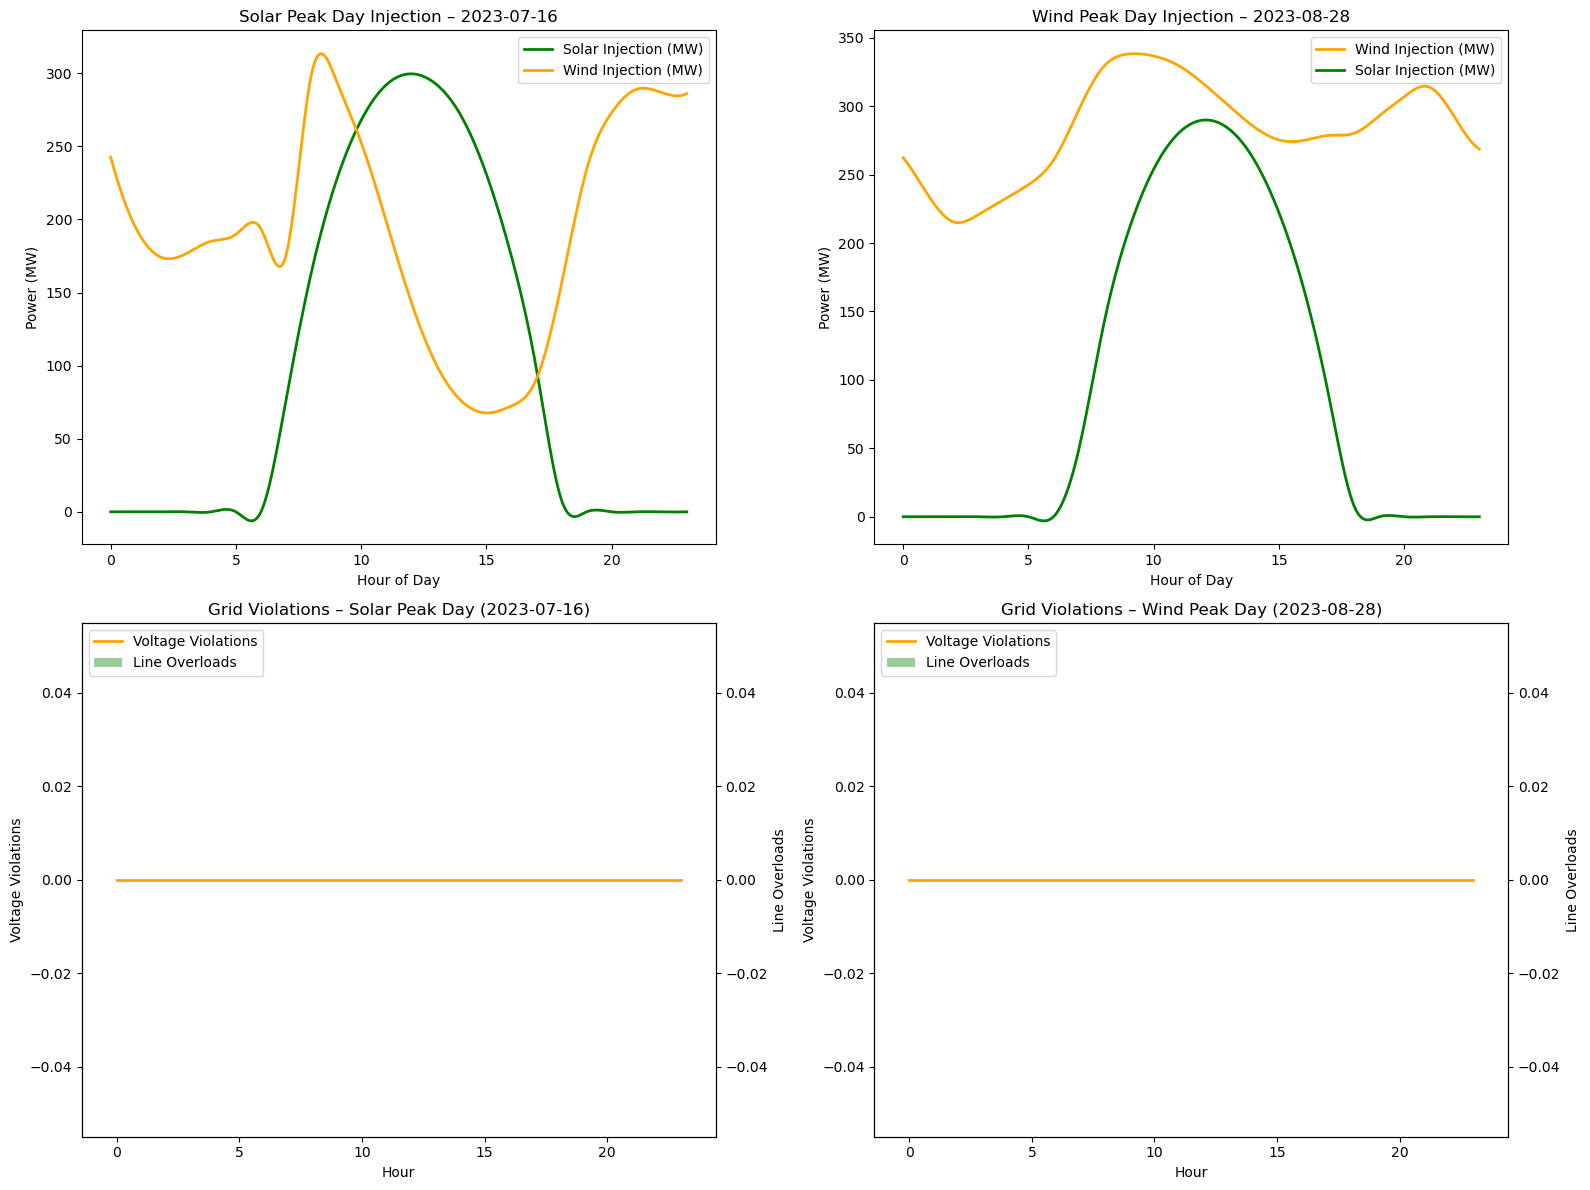

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# --- Load data ---
df = pd.read_csv("annual_min.csv")


# ---------- Setup ----------
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Date'] = df['Timestamp'].dt.date
df['Hour'] = df['Timestamp'].dt.hour

df['Voltage_Violations'] = pd.to_numeric(df['Voltage_Violations'], errors='coerce').fillna(0)
df['Overload_Violations'] = pd.to_numeric(df['Overload_Violations'], errors='coerce').fillna(0)

# Identify peak days for solar and wind injection
daily_totals = df.groupby('Date').agg({
    'Solar_Injection_MW': 'sum',
    'Wind_Injection_MW': 'sum'
})
peak_solar_day = daily_totals['Solar_Injection_MW'].idxmax()
peak_wind_day = daily_totals['Wind_Injection_MW'].idxmax()

solar_day_df = df[df['Date'] == peak_solar_day].sort_values('Hour')
wind_day_df = df[df['Date'] == peak_wind_day].sort_values('Hour')

# ---------- Helper for smoothing ----------
def smooth_line(x, y):
    x_new = np.linspace(min(x), max(x), 300)
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_new)
    return x_new, y_smooth

# ---------- Create 2x2 subplot ----------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# --- 1. Solar Peak Day Injection ---
x1, y1 = smooth_line(solar_day_df['Hour'], solar_day_df['Solar_Injection_MW'])
x2, y2 = smooth_line(solar_day_df['Hour'], solar_day_df['Wind_Injection_MW'])

axes[0, 0].plot(x1, y1, label="Solar Injection (MW)", color='green', linewidth=2)
axes[0, 0].plot(x2, y2, label="Wind Injection (MW)", color='orange',  linewidth=2)
axes[0, 0].set_title(f"Solar Peak Day Injection – {peak_solar_day}")
axes[0, 0].set_xlabel("Hour of Day")
axes[0, 0].set_ylabel("Power (MW)")
axes[0, 0].grid(False)
axes[0, 0].legend()

# --- 2. Wind Peak Day Injection ---
x1, y1 = smooth_line(wind_day_df['Hour'], wind_day_df['Wind_Injection_MW'])
x2, y2 = smooth_line(wind_day_df['Hour'], wind_day_df['Solar_Injection_MW'])

axes[0, 1].plot(x1, y1, label="Wind Injection (MW)", color='orange', linewidth=2)
axes[0, 1].plot(x2, y2, label="Solar Injection (MW)", color='green', linewidth=2)
axes[0, 1].set_title(f"Wind Peak Day Injection – {peak_wind_day}")
axes[0, 1].set_xlabel("Hour of Day")
axes[0, 1].set_ylabel("Power (MW)")
axes[0, 1].grid(False)
axes[0, 1].legend()

# --- 3. Grid Violations – Solar Peak Day ---
axes[1, 0].plot(solar_day_df['Hour'], solar_day_df['Voltage_Violations'],
                color='orange', linewidth=2, label='Voltage Violations')
axes[1, 0].set_xlabel("Hour")
axes[1, 0].set_ylabel("Voltage Violations", color='black')
axes[1, 0].tick_params(axis='y', labelcolor='black')
axes[1, 0].grid(False)

ax2 = axes[1, 0].twinx()
ax2.bar(solar_day_df['Hour'], solar_day_df['Overload_Violations'],
        color='green', alpha=0.4, width=0.5, label='Line Overloads')
ax2.set_ylabel("Line Overloads", color='black')
ax2.tick_params(axis='y', labelcolor='black')

lines_1, labels_1 = axes[1, 0].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
axes[1, 0].legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
axes[1, 0].set_title(f"Grid Violations – Solar Peak Day ({peak_solar_day})")

# --- 4. Grid Violations – Wind Peak Day ---
axes[1, 1].plot(wind_day_df['Hour'], wind_day_df['Voltage_Violations'],
                color='orange', linewidth=2, label='Voltage Violations')
axes[1, 1].set_xlabel("Hour")
axes[1, 1].set_ylabel("Voltage Violations", color='black')
axes[1, 1].tick_params(axis='y', labelcolor='black')
axes[1, 1].grid(False)

ax2 = axes[1, 1].twinx()
ax2.bar(wind_day_df['Hour'], wind_day_df['Overload_Violations'],
        color='green', alpha=0.4, width=0.5, label='Line Overloads')
ax2.set_ylabel("Line Overloads", color='black')
ax2.tick_params(axis='y', labelcolor='black')

lines_1, labels_1 = axes[1, 1].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
axes[1, 1].legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
axes[1, 1].set_title(f"Grid Violations – Wind Peak Day ({peak_wind_day})")

plt.tight_layout()
plt.show()


In [63]:
# Find peak/low days
daily_totals = df.groupby('Date').agg({
    'Solar_Injection_MW': 'sum',
    'Wind_Injection_MW': 'sum'
})

peak_solar_day = daily_totals['Solar_Injection_MW'].idxmax()
peak_wind_day  = daily_totals['Wind_Injection_MW'].idxmax()
low_solar_day  = daily_totals['Solar_Injection_MW'].idxmin()
low_wind_day   = daily_totals['Wind_Injection_MW'].idxmin()

print("Peak solar day:", peak_solar_day)
print("Peak wind day:", peak_wind_day)
print("Low solar day:", low_solar_day)
print("Low wind day:", low_wind_day)

# Check if same
print("Peak day same for solar & wind?", peak_solar_day == peak_wind_day)
print("Low day same for solar & wind?", low_solar_day == low_wind_day)


Peak solar day: 2023-07-16
Peak wind day: 2023-08-28
Low solar day: 2024-01-01
Low wind day: 2023-03-01
Peak day same for solar & wind? False
Low day same for solar & wind? False


Low solar day (full 24h): 2023-01-24
Low wind day (full 24h): 2023-03-01


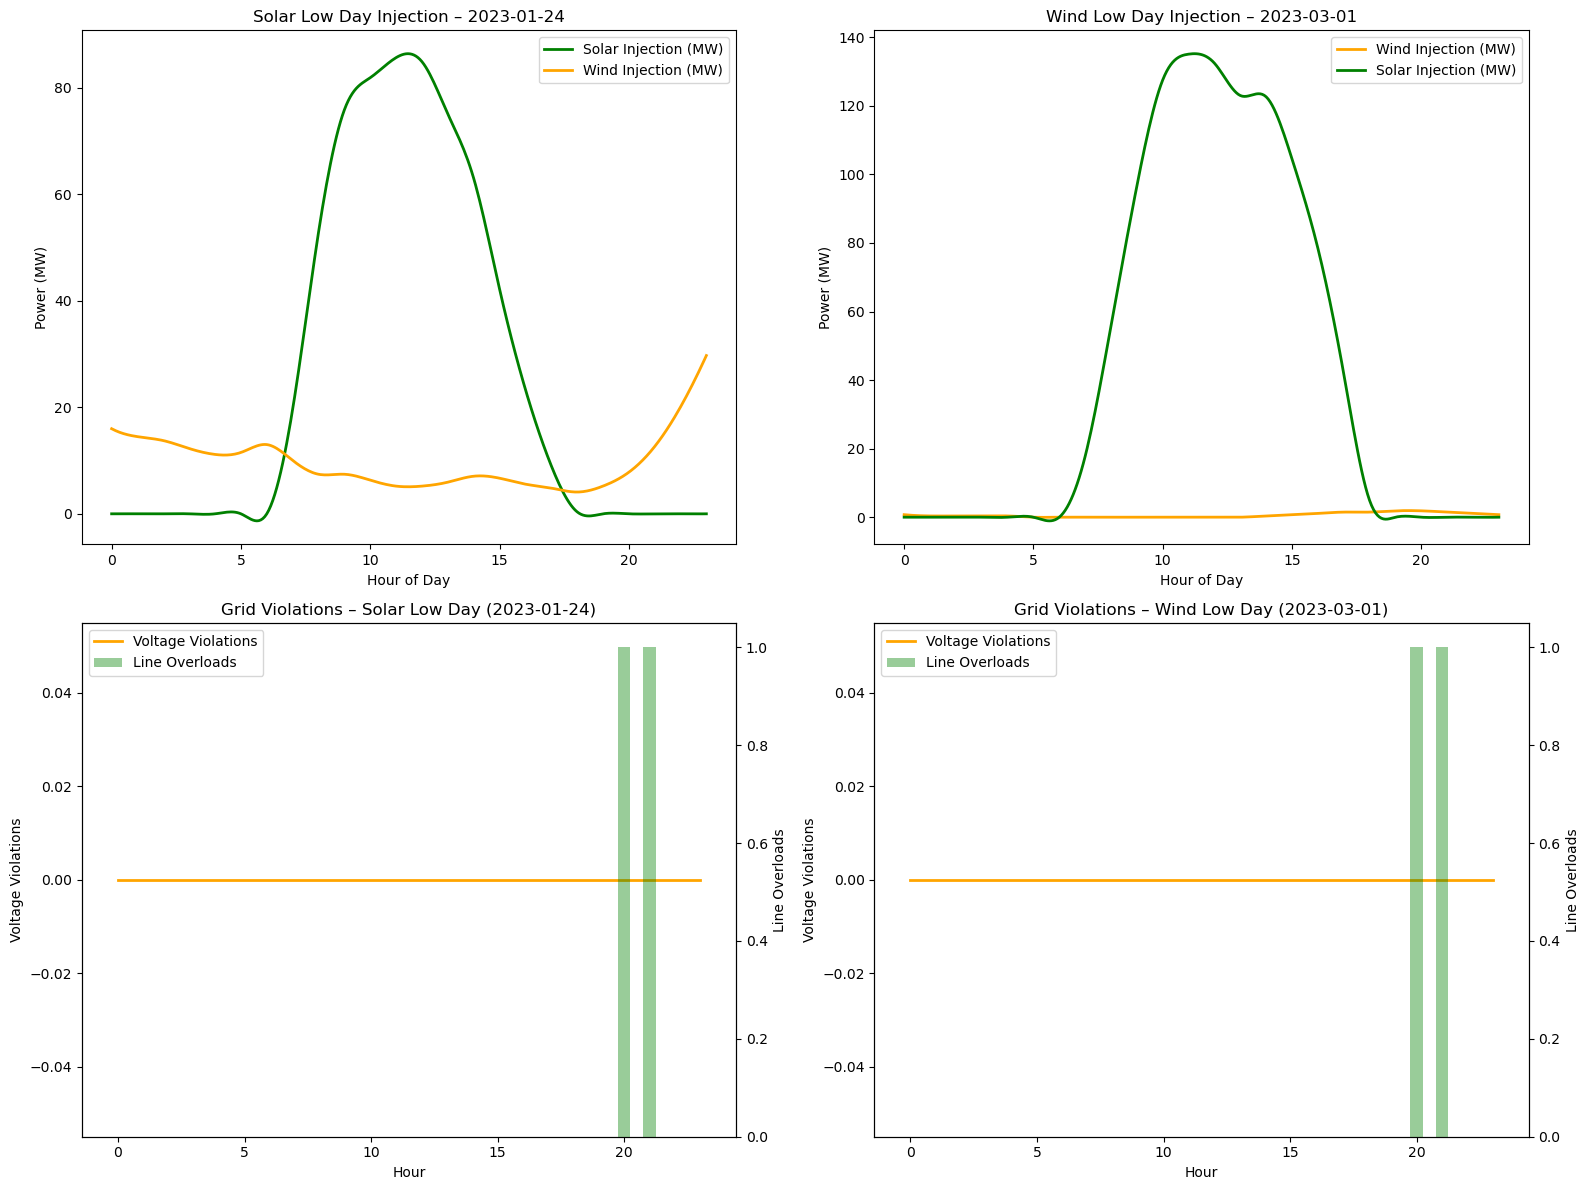

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# ---------- Load data ----------
df = pd.read_csv("annual_min.csv")

# ---------- Preprocess ----------
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Date'] = df['Timestamp'].dt.date
df['Hour'] = df['Timestamp'].dt.hour

# Ensure numeric values, fill missing with 0
df['Voltage_Violations'] = pd.to_numeric(df['Voltage_Violations'], errors='coerce').fillna(0)
df['Overload_Violations'] = pd.to_numeric(df['Overload_Violations'], errors='coerce').fillna(0)
df['Solar_Injection_MW'] = pd.to_numeric(df['Solar_Injection_MW'], errors='coerce').fillna(0)
df['Wind_Injection_MW'] = pd.to_numeric(df['Wind_Injection_MW'], errors='coerce').fillna(0)

# ---------- Identify low days with complete 24-hour data ----------
daily_counts = df.groupby('Date')['Hour'].count()
complete_days = daily_counts[daily_counts == 24].index  # Only days with full 24 hours

daily_totals_complete = df[df['Date'].isin(complete_days)].groupby('Date').agg({
    'Solar_Injection_MW': 'sum',
    'Wind_Injection_MW': 'sum'
})

low_solar_day = daily_totals_complete['Solar_Injection_MW'].idxmin()
low_wind_day  = daily_totals_complete['Wind_Injection_MW'].idxmin()

solar_low_df = df[df['Date'] == low_solar_day].sort_values('Hour')
wind_low_df  = df[df['Date'] == low_wind_day].sort_values('Hour')

print("Low solar day (full 24h):", low_solar_day)
print("Low wind day (full 24h):", low_wind_day)

# ---------- Helper function for smoothing ----------
def smooth_line(x, y):
    if len(x) < 4:  # Spline requires at least 4 points
        return x, y
    x_new = np.linspace(min(x), max(x), 300)
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_new)
    return x_new, y_smooth

# ---------- Create 2x2 subplot ----------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# --- 1. Solar Low Day Injection (with normal wind) ---
x1, y1 = smooth_line(solar_low_df['Hour'], solar_low_df['Solar_Injection_MW'])
x2, y2 = smooth_line(solar_low_df['Hour'], solar_low_df['Wind_Injection_MW'])

axes[0, 0].plot(x1, y1, label="Solar Injection (MW)", color='green', linewidth=2)
axes[0, 0].plot(x2, y2, label="Wind Injection (MW)", color='orange', linewidth=2)
axes[0, 0].set_title(f"Solar Low Day Injection – {low_solar_day}")
axes[0, 0].set_xlabel("Hour of Day")
axes[0, 0].set_ylabel("Power (MW)")
axes[0, 0].grid(False)
axes[0, 0].legend()

# --- 2. Wind Low Day Injection (with normal solar) ---
x1, y1 = smooth_line(wind_low_df['Hour'], wind_low_df['Wind_Injection_MW'])
x2, y2 = smooth_line(wind_low_df['Hour'], wind_low_df['Solar_Injection_MW'])

axes[0, 1].plot(x1, y1, label="Wind Injection (MW)", color='orange', linewidth=2)
axes[0, 1].plot(x2, y2, label="Solar Injection (MW)", color='green', linewidth=2)
axes[0, 1].set_title(f"Wind Low Day Injection – {low_wind_day}")
axes[0, 1].set_xlabel("Hour of Day")
axes[0, 1].set_ylabel("Power (MW)")
axes[0, 1].grid(False)
axes[0, 1].legend()

# --- 3. Grid Violations – Solar Low Day ---
axes[1, 0].plot(solar_low_df['Hour'], solar_low_df['Voltage_Violations'],
                color='orange', linewidth=2, label='Voltage Violations')
axes[1, 0].set_xlabel("Hour")
axes[1, 0].set_ylabel("Voltage Violations", color='black')
axes[1, 0].tick_params(axis='y', labelcolor='black')
axes[1, 0].grid(False)

ax2 = axes[1, 0].twinx()
ax2.bar(solar_low_df['Hour'], solar_low_df['Overload_Violations'],
        color='green', alpha=0.4, width=0.5, label='Line Overloads')
ax2.set_ylabel("Line Overloads", color='black')
ax2.tick_params(axis='y', labelcolor='black')

lines_1, labels_1 = axes[1, 0].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
axes[1, 0].legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
axes[1, 0].set_title(f"Grid Violations – Solar Low Day ({low_solar_day})")

# --- 4. Grid Violations – Wind Low Day ---
axes[1, 1].plot(wind_low_df['Hour'], wind_low_df['Voltage_Violations'],
                color='orange', linewidth=2, label='Voltage Violations')
axes[1, 1].set_xlabel("Hour")
axes[1, 1].set_ylabel("Voltage Violations", color='black')
axes[1, 1].tick_params(axis='y', labelcolor='black')
axes[1, 1].grid(False)

ax2 = axes[1, 1].twinx()
ax2.bar(wind_low_df['Hour'], wind_low_df['Overload_Violations'],
        color='green', alpha=0.4, width=0.5, label='Line Overloads')
ax2.set_ylabel("Line Overloads", color='black')
ax2.tick_params(axis='y', labelcolor='black')

lines_1, labels_1 = axes[1, 1].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
axes[1, 1].legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
axes[1, 1].set_title(f"Grid Violations – Wind Low Day ({low_wind_day})")

plt.tight_layout()
plt.show()


In [71]:
import pandas as pd

# Your lines data
lines_data = [
    {"from_bus": "Morogoro", "to_bus": "Iringa", "voltage_kv": 220, "length_km": 130, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Iringa", "to_bus": "Dodoma", "voltage_kv": 220, "length_km": 107, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Mwanza", "voltage_kv": 220, "length_km": 140, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Iringa", "to_bus": "Mbeya", "voltage_kv": 220, "length_km": 220, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dar es salaam", "to_bus": "Pwani", "voltage_kv": 220, "length_km": 48.8, "rating_mva": 999, "cable_type": "ACSR_Bluejay_3x", "area": 565.5 * 3},
    {"from_bus": "Pwani", "to_bus": "Morogoro", "voltage_kv": 220, "length_km": 82, "rating_mva": 999, "cable_type": "ACSR_Bluejay_3x", "area": 565.5 * 3},
    {"from_bus": "JNHPP", "to_bus": "Morogoro", "voltage_kv": 400, "length_km": 160, "rating_mva": 732, "cable_type": "ACSR_Zebra", "area": 485},
    {"from_bus": "Pwani", "to_bus": "Kilimanjaro", "voltage_kv": 220, "length_km": 175, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Kilimanjaro", "to_bus": "Tanga", "voltage_kv": 220, "length_km": 60, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Tabora", "voltage_kv": 220, "length_km": 203, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Singida", "to_bus": "Manyara", "voltage_kv": 220, "length_km": 80, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Manyara", "to_bus": "Arusha", "voltage_kv": 220, "length_km": 22, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dar es salaam", "to_bus": "Zanzibar", "voltage_kv": 220, "length_km": 64, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Dodoma", "to_bus": "Singida", "voltage_kv": 220, "length_km": 216.5, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Singida", "to_bus": "Shinyanga", "voltage_kv": 220, "length_km": 228.9, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5},
    {"from_bus": "Shinyanga", "to_bus": "Geita", "voltage_kv": 220, "length_km": 120, "rating_mva": 333, "cable_type": "ACSR_Bluejay", "area": 565.5}
]

# Convert to DataFrame
lines_df = pd.DataFrame(lines_data)

# Add a column for Loading_Percent (example, replace with your actual simulation data)
# For demonstration, let's assume we have some loading percentages
import numpy as np
np.random.seed(0)
lines_df['Loading_Percent'] = np.random.randint(50, 120, size=len(lines_df))  # random load between 50% and 120%

# Identify overloaded lines (>100%)
overloaded_lines = lines_df[lines_df['Loading_Percent'] > 100]

# Sort by highest loading first
overloaded_lines = overloaded_lines.sort_values(by='Loading_Percent', ascending=False)

# Display
print("Overloaded lines:")
print(overloaded_lines[['from_bus', 'to_bus', 'voltage_kv', 'rating_mva', 'Loading_Percent']])


Overloaded lines:
         from_bus   to_bus  voltage_kv  rating_mva  Loading_Percent
3          Iringa    Mbeya         220         333              117
4   Dar es salaam    Pwani         220         999              117
10        Singida  Manyara         220         333              115
2       Shinyanga   Mwanza         220         333              114
9       Shinyanga   Tabora         220         333              108


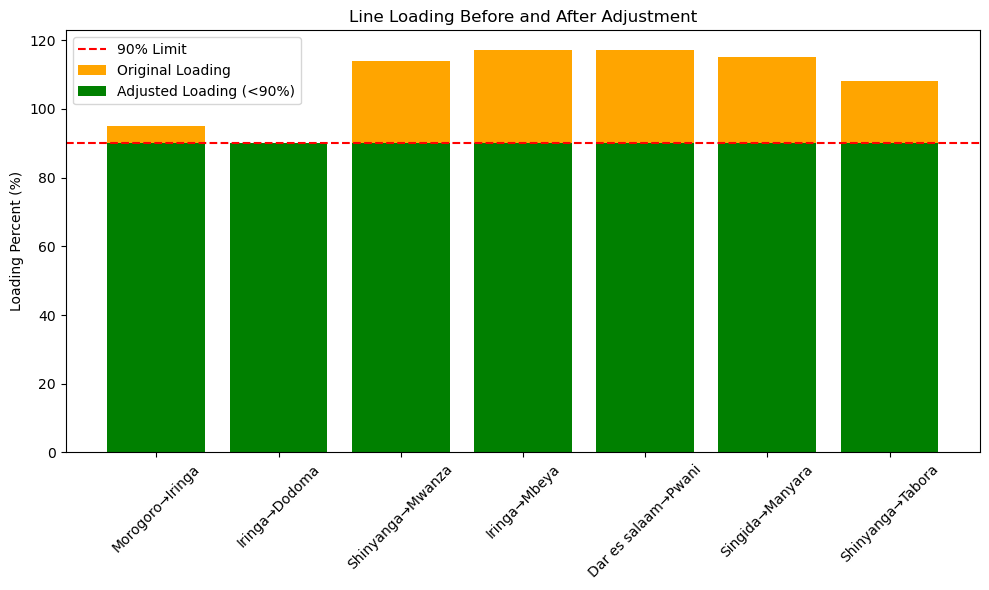

        from_bus   to_bus  voltage_kv  rating_mva  Loading_Percent  \
0       Morogoro   Iringa         220         333               95   
1         Iringa   Dodoma         220         333               90   
2      Shinyanga   Mwanza         220         333              114   
3         Iringa    Mbeya         220         333              117   
4  Dar es salaam    Pwani         220         999              117   
5        Singida  Manyara         220         333              115   
6      Shinyanga   Tabora         220         333              108   

   Adjusted_MVA  Adjusted_Loading_Percent  
0         351.5                      90.0  
1         333.0                      90.0  
2         421.8                      90.0  
3         432.9                      90.0  
4        1298.7                      90.0  
5         425.5                      90.0  
6         399.6                      90.0  


In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Example lines data and loading
# -----------------------------
lines_data = [
    {"from_bus": "Morogoro", "to_bus": "Iringa", "voltage_kv": 220, "rating_mva": 333, "Loading_Percent": 95},
    {"from_bus": "Iringa", "to_bus": "Dodoma", "voltage_kv": 220, "rating_mva": 333, "Loading_Percent": 90},
    {"from_bus": "Shinyanga", "to_bus": "Mwanza", "voltage_kv": 220, "rating_mva": 333, "Loading_Percent": 114},
    {"from_bus": "Iringa", "to_bus": "Mbeya", "voltage_kv": 220, "rating_mva": 333, "Loading_Percent": 117},
    {"from_bus": "Dar es salaam", "to_bus": "Pwani", "voltage_kv": 220, "rating_mva": 999, "Loading_Percent": 117},
    {"from_bus": "Singida", "to_bus": "Manyara", "voltage_kv": 220, "rating_mva": 333, "Loading_Percent": 115},
    {"from_bus": "Shinyanga", "to_bus": "Tabora", "voltage_kv": 220, "rating_mva": 333, "Loading_Percent": 108},
]

lines_df = pd.DataFrame(lines_data)

# -----------------------------
# Adjust overloaded lines to be below 90%
# -----------------------------
target_loading = 90  # percent

def adjust_line_rating(row, target=target_loading):
    if row['Loading_Percent'] > target:
        return row['rating_mva'] * row['Loading_Percent'] / target
    else:
        return row['rating_mva']

lines_df['Adjusted_MVA'] = lines_df.apply(adjust_line_rating, axis=1)
lines_df['Adjusted_Loading_Percent'] = (lines_df['Loading_Percent'] * lines_df['rating_mva'] / lines_df['Adjusted_MVA']).round(2)

# -----------------------------
# Plot before vs after with orange & green
# -----------------------------
x_labels = lines_df['from_bus'] + "→" + lines_df['to_bus']
plt.figure(figsize=(10,6))
plt.bar(x_labels, lines_df['Loading_Percent'], color='orange', label='Original Loading')
plt.bar(x_labels, lines_df['Adjusted_Loading_Percent'], color='green', label=f'Adjusted Loading (<{target_loading}%)')
plt.axhline(target_loading, color='red', linestyle='--', label=f'{target_loading}% Limit')
plt.ylabel('Loading Percent (%)')
plt.xticks(rotation=45)
plt.title('Line Loading Before and After Adjustment')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Print table of adjustments
# -----------------------------
print(lines_df[['from_bus', 'to_bus', 'voltage_kv', 'rating_mva', 'Loading_Percent', 'Adjusted_MVA', 'Adjusted_Loading_Percent']])


Adjusted capacities: Solar = 750.0 MW, Wind = 800.0 MW
        from_bus    to_bus  voltage_kv  rating_mva  Loading_Percent
0         Iringa     Mbeya         220         333             80.0
1  Dar es salaam     Pwani         220         999             80.0
2      Shinyanga    Mwanza         220         333             80.0
3         Iringa    Mbeya2         220         333             80.0
4        Singida   Manyara         220         333             80.0
5      Shinyanga    Tabora         220         333             80.0
6        Singida  Manyara2         220         333             80.0


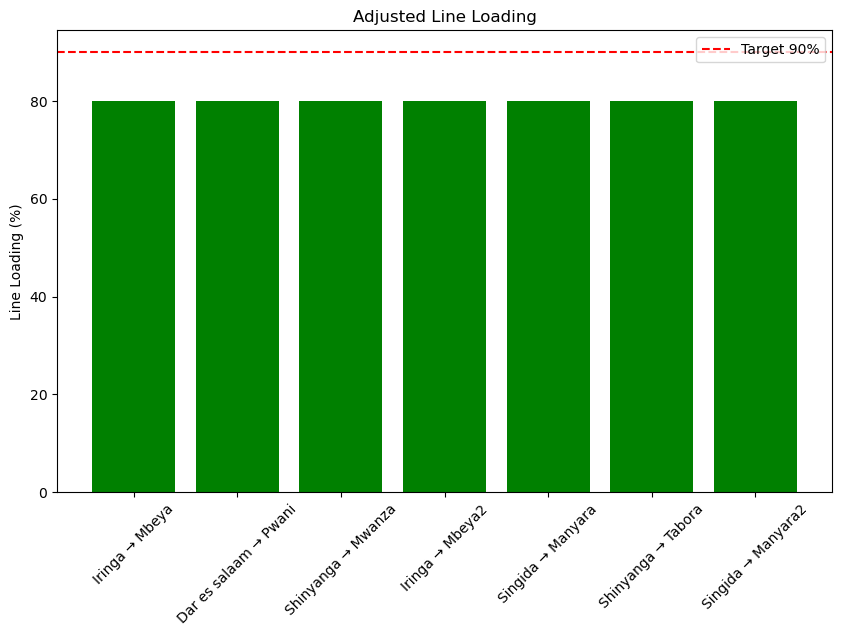

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample lines dataframe
lines = pd.DataFrame({
    'from_bus': ['Iringa', 'Dar es salaam', 'Shinyanga', 'Iringa', 'Singida', 'Shinyanga', 'Singida'],
    'to_bus': ['Mbeya', 'Pwani', 'Mwanza', 'Mbeya2', 'Manyara', 'Tabora', 'Manyara2'],
    'voltage_kv': [220]*7,
    'rating_mva': [333, 999, 333, 333, 333, 333, 333]
})

# Initial capacities (MW)
solar_capacity = 750
wind_capacity = 800

# Target loading percent
target_loading = 90

# Function to calculate line loading
def calculate_loading(lines_df, solar, wind, base_loading=None):
    if base_loading is None:
        # Dynamic placeholder: assume current loading 80% as starting point
        base_loading = [80]*len(lines_df)
    scaling_factor = (solar + wind) / (solar_capacity + wind_capacity)
    lines_df['Loading_Percent'] = [min(lf * scaling_factor, 150) for lf in base_loading]
    return lines_df

# Function to adjust solar and wind to meet target loading
def adjust_generation(lines_df, solar, wind, target_loading):
    adjusted_solar = solar
    adjusted_wind = wind

    while True:
        loading_df = calculate_loading(lines_df.copy(), adjusted_solar, adjusted_wind)
        overloaded = loading_df[loading_df['Loading_Percent'] > target_loading]
        if overloaded.empty:
            break
        # Reduce solar and wind proportionally (5% step)
        adjusted_solar *= 0.95
        adjusted_wind *= 0.95

    # Final loading dataframe
    final_loading = calculate_loading(lines_df.copy(), adjusted_solar, adjusted_wind)
    return adjusted_solar, adjusted_wind, final_loading

# Run adjustment
final_solar, final_wind, final_loading = adjust_generation(lines, solar_capacity, wind_capacity, target_loading)

print(f"Adjusted capacities: Solar = {final_solar:.1f} MW, Wind = {final_wind:.1f} MW")
print(final_loading)

# Plot bar chart with orange (overloaded) and green (safe)
colors = ['orange' if x > target_loading else 'green' for x in final_loading['Loading_Percent']]

plt.figure(figsize=(10,6))
plt.bar(final_loading['from_bus'] + ' → ' + final_loading['to_bus'], 
        final_loading['Loading_Percent'], color=colors)
plt.axhline(target_loading, color='red', linestyle='--', label='Target 90%')
plt.ylabel('Line Loading (%)')
plt.xticks(rotation=45)
plt.title('Adjusted Line Loading')
plt.legend()
plt.show()
